# Classification of table rows with custom measurements
This notebook demonstrates using the apoc `TableRowClasifer`

In [1]:
import apoc
import numpy as np
from numpy.random import default_rng
from skimage import draw
from skimage.measure import regionprops_table
import pyclesperanto_prototype as cle
import pandas as pd

In [2]:
cle.select_device()

<gfx90c on Platform: AMD Accelerated Parallel Processing (2 refs)>

## Example data
We start by setting up an image with circles and squares

In [3]:
def get_square_indices(center_row, center_column, half_width=5):
    """Get the indices to fill in a square"""
    start = np.array([center_row, center_column]) - half_width
    extent = (2 * half_width, 2 * half_width)
    return draw.rectangle(start, extent=extent)


def get_circle_indices(center_row, center_column, half_width=5):
    """Get the indices to fill in a circle"""
    center = (center_row, center_column)
    radius = half_width
    return draw.disk(center, radius)


In [4]:
# create a label image with randomly placed squares and circles
rng = default_rng(42)

label_image = np.zeros((200, 200), dtype=np.uint16)

label_index = 1
ground_truth = []
for center_row in np.arange(10, 200, 20):
    for center_column in np.arange(10, 200, 20):
        shape_type = rng.choice(["square", "circle"])
        if shape_type == "square":
            shape_function = get_square_indices
            ground_truth.append(1)
        else:
            shape_function = get_circle_indices
            ground_truth.append(2)
        shape_rows, shape_columns = shape_function(center_row, center_column, half_width=5)
        
        label_image[shape_rows, shape_columns] = label_index
    
        label_index += 1

ground_truth = np.asarray(ground_truth)

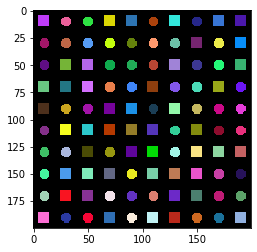

In [5]:
# view the label image
cle.imshow(label_image, labels=True)

## Feature extraction
We now set up a table of measurements. Here we use [scikit-image's regionprops_table](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops_table).

In [6]:
# measure the  using skimage's regionprops_table function
measurement_table = regionprops_table(label_image, properties=("label", "area", "perimeter", "extent", "eccentricity"))
labels = measurement_table.pop("label")

In [7]:
# extract the first 50 measurements to use as training
measurements_training = {key: values[0:50] for key, values in measurement_table.items()}
ground_truth_training = ground_truth[0:50]

## Classifier training
We next train a `TableRowClassifier` and save it to a `.cl` file.

In [8]:
# create the classifier and train it
cl_filename = "shape_classifier.model.cl"
num_trees = 1000
max_depth = 1

apoc.erase_classifier(cl_filename)
classifier = apoc.TableRowClassifier(cl_filename, num_ensembles=num_trees, max_depth=max_depth)
classifier.train(measurements_training, ground_truth_training)

## Prediction
Next, we use the classifier to generate a prediction and visualize it as parametric / classification label image.

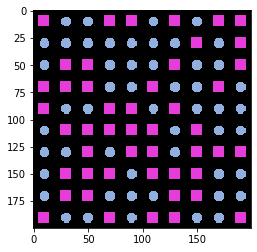

In [9]:
# predict on the full table
prediction = classifier.predict(measurement_table)

# prefix class==0 for the background (first entry, label=0)
annotation = [0] + prediction.tolist()

# create an image where the objects are colored by the predicted shape
shape_image = cle.replace_intensities(label_image, annotation)

cle.imshow(shape_image, labels=True, min_display_intensity=0)

## Classifier statistics
We can also visualize the share of the decision trees take a given parameter into account when making their decision. This allows us to differentiate parameters that are useful for making the classification from those which are not.

Note: Multiple of these parameters may be correleated. If you enter 11 parameters, which all allow to make the classification similarly, but 10 of those are correlated, these 10 may appear with a share of about 0.05 while the 11th parameter has a share of 0.5. Thus, study these values with care.

In [10]:
def colorize(styler):
    styler.background_gradient(axis=None, cmap="rainbow")
    return styler

shares, counts = classifier.statistics()
df = pd.DataFrame(shares).T
df.style.pipe(colorize)

,0
area,0.309000
perimeter,0.331000
extent,0.360000
eccentricity,0.000000


In [11]:
classifier.train(pd.DataFrame(measurements_training)[["area", "perimeter"]], ground_truth_training)
shares, counts = classifier.statistics()
df = pd.DataFrame(shares).T
df.style.pipe(colorize)

,0
area,0.483000
perimeter,0.517000
